# Deep Learning Lab Assignment 3: Optimizers

    Ayush Abrol B20AI052

---

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.models as models
import copy
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up the environment to GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading the pre-trained model (ResNet18 with 1000 classes of ImageNet) 

In [3]:
model = models.resnet18(pretrained=True).to(device)
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The output layer has the output classes as 1000 because the dataset used is ImageNet which has 1000 classes.

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Loading the CIFAR100 dataset with batch size = 128

In [5]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# print the shape of the data
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
print(len(trainset.classes))

100


### Visualizing the CIFAR100 dataset

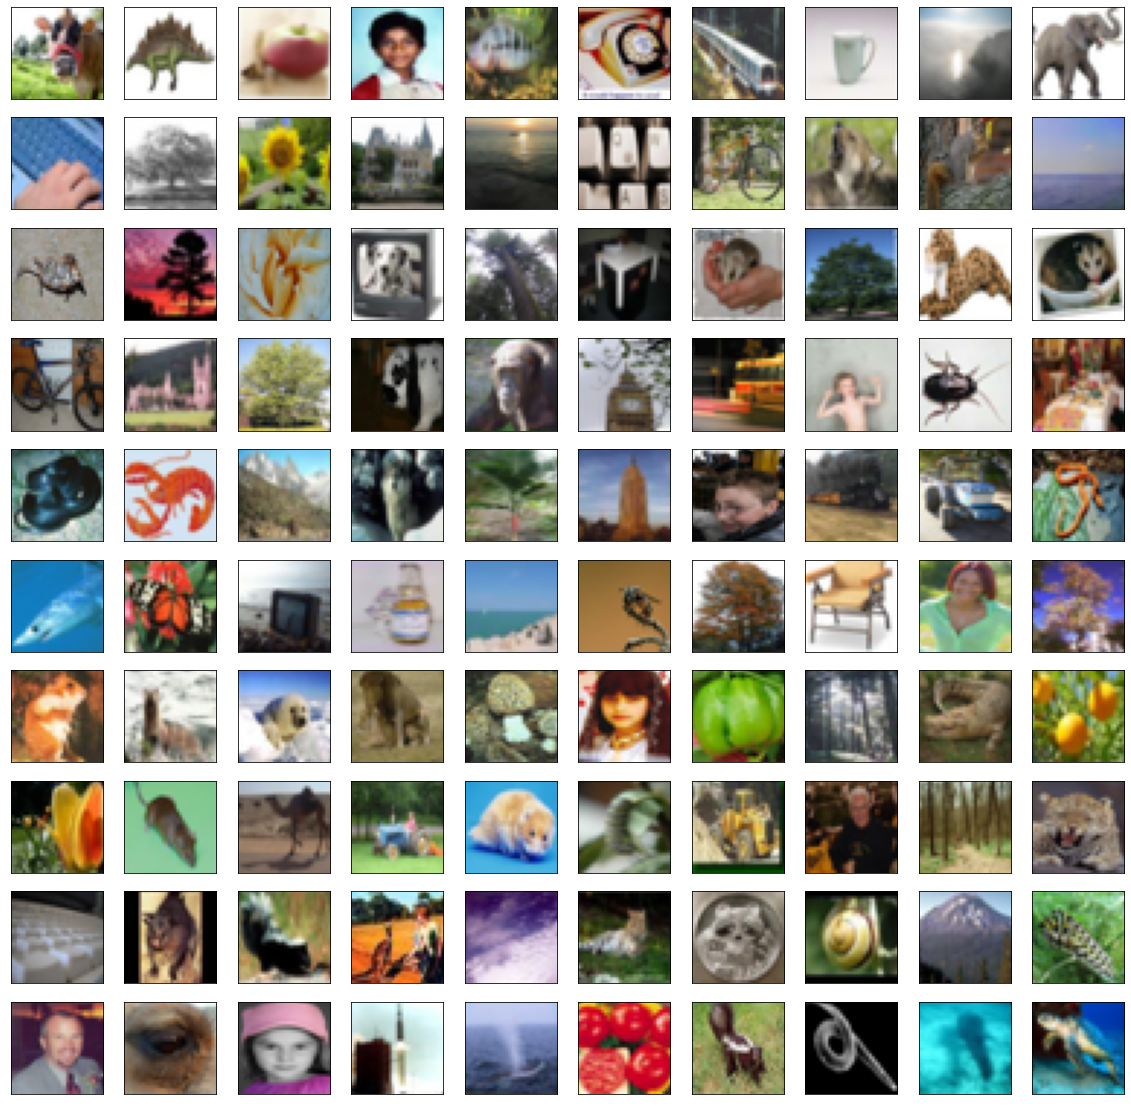

In [9]:
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainset.data[i])
    plt.xlabel(trainset.classes[trainset.targets[i]], color='white')
plt.show()

## Finetuning the ResNet18 model on CIFAR100 dataset for classification task

In [8]:
model.fc.in_features

512

### Changing the output layer of the model to 100 classes for the CIFAR100 dataset

In [9]:
model.fc = nn.Linear(512, 100).to(device)

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now, the output layer has the output classes as 100 because the dataset used is CIFAR100 which has 100 classes.

In [11]:
model_adam = model 

## Defining the loss function and the Adam optimizer as mentioned in the question

In [12]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss

optimizer_adam = optim.Adam(model.parameters(), lr=0.001) # Learning rate = 0.001

## Defining the training function for the finetuned model

In [13]:
def train_model(model, optimizer, epochs, train_loss, train_accuracy):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        avg_loss = running_loss/len(trainloader)
        avg_accuracy = correct/len(trainloader.dataset)
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print("Epoch:", epoch+1, "Training Loss: ", avg_loss, "\t Training Accuracy: ", avg_accuracy)
    print("Training complete!")
    return train_loss, train_accuracy

## Training the model with Adam optimizer for 10 epochs

In [16]:
train_loss_adam = []
train_accuracy_adam = []
train_loss_adam, train_accuracy_adam = train_model(model_adam, optimizer_adam, 10, train_loss_adam, train_accuracy_adam)

Epoch: 1 Training Loss:  2.9484739785304157 	 Training Accuracy:  0.26724
Epoch: 2 Training Loss:  2.2712170592964154 	 Training Accuracy:  0.39784
Epoch: 3 Training Loss:  2.0303160049726285 	 Training Accuracy:  0.45364
Epoch: 4 Training Loss:  1.8612307130223344 	 Training Accuracy:  0.48918
Epoch: 5 Training Loss:  1.742896107151685 	 Training Accuracy:  0.51608
Epoch: 6 Training Loss:  1.6437042073520554 	 Training Accuracy:  0.54014
Epoch: 7 Training Loss:  1.5552414850810605 	 Training Accuracy:  0.56172
Epoch: 8 Training Loss:  1.479739181830755 	 Training Accuracy:  0.5801
Epoch: 9 Training Loss:  1.4337613491146155 	 Training Accuracy:  0.58896
Epoch: 10 Training Loss:  1.4283446756470235 	 Training Accuracy:  0.5905
Training complete!


## Training the model with AdaGrad optimizer for 10 epochs

In [17]:
model_adagrad = models.resnet18(pretrained=True).to(device)
model_adagrad.fc = nn.Linear(512, 100).to(device)
optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.001)

In [18]:
train_loss_adagrad = []
train_accuracy_adagrad = []
train_loss_adagrad, train_accuracy_adagrad = train_model(model_adagrad, optimizer_adagrad, 10, train_loss_adagrad, train_accuracy_adagrad)

Epoch: 1 Training Loss:  3.0250805558450997 	 Training Accuracy:  0.27354
Epoch: 2 Training Loss:  2.3077528626107804 	 Training Accuracy:  0.40312
Epoch: 3 Training Loss:  2.0910195356134866 	 Training Accuracy:  0.44542
Epoch: 4 Training Loss:  1.9537283380318176 	 Training Accuracy:  0.4775
Epoch: 5 Training Loss:  1.8591367545944955 	 Training Accuracy:  0.49814
Epoch: 6 Training Loss:  1.7798262651619094 	 Training Accuracy:  0.51732
Epoch: 7 Training Loss:  1.720074597831882 	 Training Accuracy:  0.53222
Epoch: 8 Training Loss:  1.6647907562572937 	 Training Accuracy:  0.54402
Epoch: 9 Training Loss:  1.6155047291684943 	 Training Accuracy:  0.5575
Epoch: 10 Training Loss:  1.5725262509587477 	 Training Accuracy:  0.5659
Training complete!


## Training the model with RMSProp Optimizer for 10 epochs

In [18]:
model_rmsprop = models.resnet18(pretrained=True).to(device)
model_rmsprop.fc = nn.Linear(512, 100).to(device)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.001)

In [19]:
train_loss_rmsprop = []
train_accuracy_rmsprop = []
train_loss_rmsprop, train_accuracy_rmsprop = train_model(model_rmsprop, optimizer_rmsprop, 10, train_loss_rmsprop, train_accuracy_rmsprop)

Epoch: 1 Training Loss:  4.157836231124371 	 Training Accuracy:  0.06914
Epoch: 2 Training Loss:  3.093010031048904 	 Training Accuracy:  0.218
Epoch: 3 Training Loss:  2.6508499496733138 	 Training Accuracy:  0.30546
Epoch: 4 Training Loss:  2.403722416104563 	 Training Accuracy:  0.36086
Epoch: 5 Training Loss:  2.221684978136321 	 Training Accuracy:  0.39946
Epoch: 6 Training Loss:  2.0926798091215244 	 Training Accuracy:  0.43192
Epoch: 7 Training Loss:  1.9947946486265764 	 Training Accuracy:  0.4553
Epoch: 8 Training Loss:  1.8992740839643552 	 Training Accuracy:  0.47602
Epoch: 9 Training Loss:  1.8325910464577053 	 Training Accuracy:  0.49006
Epoch: 10 Training Loss:  1.7541112707703925 	 Training Accuracy:  0.50802
Training complete!


## Reporting the accuracy and top-5 accuracy of the Adam Optimizer model on the test set

In [23]:
test_loss_adam = []
test_accuracy_adam = []
model_adam.eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_adam(inputs)
        loss = criterion(outputs, labels)
        test_loss_adam.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy_adam.append(correct/len(labels))
        # Save the top-5 test accuracy
        top5, top5_pred = outputs.topk(5, 1, True, True)
        top5_correct = top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred))
        top5_correct = top5_correct.sum().item()
        top5_accuracy = top5_correct/len(labels)
print("Top-5 test accuracy for Adam Optimizer: ", top5_accuracy)
print("Test Accuracy for Adam Optimizer: ", np.mean(test_accuracy_adam))

Top-5 test accuracy for Adam Optimizer:  0.875
Test Accuracy for Adam Optimizer:  0.5400514240506329


## Reporting the accuracy and top-5 accuracy of the AdaGrad Optimizer model on the test set

In [24]:
test_loss_adagrad = []
test_accuracy_adagrad = []
model_adagrad.eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_adagrad(inputs)
        loss = criterion(outputs, labels)
        test_loss_adagrad.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy_adagrad.append(correct/len(labels))
        # Save the top-5 test accuracy
        top5, top5_pred = outputs.topk(5, 1, True, True)
        top5_correct = top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred))
        top5_correct = top5_correct.sum().item()
        top5_accuracy = top5_correct/len(labels)
print("Top-5 test accuracy for Adagrad Optimizer: ", top5_accuracy)
print("Test Accuracy for Adagrad Optimizer: ", np.mean(test_accuracy_adagrad))

Top-5 test accuracy for Adagrad Optimizer:  0.8125
Test Accuracy for Adagrad Optimizer:  0.5266020569620253


## Reporting the accuracy and top-5 accuracy of the RMSProp Optimizer model on the test set

In [25]:
test_loss_rmsprop = []
test_accuracy_rmsprop = []
model_rmsprop.eval()
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_rmsprop(inputs)
        loss = criterion(outputs, labels)
        test_loss_rmsprop.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        test_accuracy_rmsprop.append(correct/len(labels))
        # Save the top-5 test accuracy
        top5, top5_pred = outputs.topk(5, 1, True, True)
        top5_correct = top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred))
        top5_correct = top5_correct.sum().item()
        top5_accuracy = top5_correct/len(labels)
print("Top-5 test accuracy for RMSProp Optimizer: ", top5_accuracy)
print("Test Accuracy for RMSProp Optimizer: ", np.mean(test_accuracy_rmsprop))

Top-5 test accuracy for RMSProp Optimizer:  0.8125
Test Accuracy for RMSProp Optimizer:  0.46914556962025317


## Plotting the training loss and accuracy for each optimizer

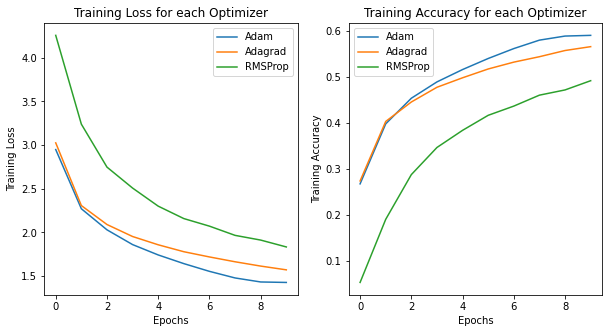

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Optimizer")
plt.plot(train_loss_adam, label="Adam")
plt.plot(train_loss_adagrad, label="Adagrad")
plt.plot(train_loss_rmsprop, label="RMSProp")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Optimizer")
plt.plot(train_accuracy_adam, label="Adam")
plt.plot(train_accuracy_adagrad, label="Adagrad")
plt.plot(train_accuracy_rmsprop, label="RMSProp")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

## Hyperparameter tuning

### Tuning weight_decay parameter for Adam Optimizer. (L2 penalty)

Training with weight decay:  0
Epoch: 1 Training Loss:  3.0040069126412083 	 Training Accuracy:  0.25722
Epoch: 2 Training Loss:  2.282144119367575 	 Training Accuracy:  0.3964
Epoch: 3 Training Loss:  2.0565178653468257 	 Training Accuracy:  0.44772
Epoch: 4 Training Loss:  1.8722970705203084 	 Training Accuracy:  0.48702
Epoch: 5 Training Loss:  1.7659459370176505 	 Training Accuracy:  0.51122
Epoch: 6 Training Loss:  1.6513387105044197 	 Training Accuracy:  0.54068
Epoch: 7 Training Loss:  1.566440521603655 	 Training Accuracy:  0.55914
Epoch: 8 Training Loss:  1.4978260524437557 	 Training Accuracy:  0.57382
Epoch: 9 Training Loss:  1.4733668888926201 	 Training Accuracy:  0.58038
Epoch: 10 Training Loss:  1.3706695103584348 	 Training Accuracy:  0.60504
Training complete!
--------------------------------------------
Training with weight decay:  0.0001
Epoch: 1 Training Loss:  3.0624556364610678 	 Training Accuracy:  0.24298
Epoch: 2 Training Loss:  2.3206360855370836 	 Training Ac

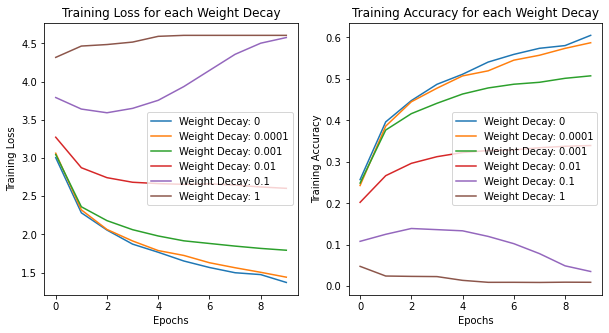

In [30]:
weight_decays = [0, 0.0001, 0.001, 0.01, 0.1, 1]
train_loss_adam_decays = []
train_accuracy_adam_decays = []
for decay in weight_decays:
    model_adam = models.resnet18(pretrained=True).to(device)
    model_adam.fc = nn.Linear(512, 100).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001, weight_decay=decay)
    train_loss_adam_decay = []
    train_accuracy_adam_decay = []
    print("Training with weight decay: ", decay)
    train_loss_adam_decay, train_accuracy_adam_decay = train_model(model_adam, optimizer_adam, 10, train_loss_adam_decay, train_accuracy_adam_decay)
    print("--------------------------------------------")
    train_loss_adam_decays.append(train_loss_adam_decay)
    train_accuracy_adam_decays.append(train_accuracy_adam_decay)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Weight Decay")
for i in range(len(weight_decays)):
    plt.plot(train_loss_adam_decays[i], label="Weight Decay: " + str(weight_decays[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Weight Decay")
for i in range(len(weight_decays)):
    plt.plot(train_accuracy_adam_decays[i], label="Weight Decay: " + str(weight_decays[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning beta1 and beta2 parameter for Adam Optimizer. (Coefficients used for computing running averages of gradient and its square)

Training with betas:  (0.9, 0.999)
Epoch: 1 Training Loss:  2.9955492324536412 	 Training Accuracy:  0.25782
Epoch: 2 Training Loss:  2.274377622262901 	 Training Accuracy:  0.3974
Epoch: 3 Training Loss:  2.0227718944744684 	 Training Accuracy:  0.45228
Epoch: 4 Training Loss:  1.8881123703154152 	 Training Accuracy:  0.48256
Epoch: 5 Training Loss:  1.7478072932918969 	 Training Accuracy:  0.51878
Epoch: 6 Training Loss:  1.648536433344302 	 Training Accuracy:  0.53926
Epoch: 7 Training Loss:  1.5684087352679514 	 Training Accuracy:  0.55812
Epoch: 8 Training Loss:  1.486082344103957 	 Training Accuracy:  0.57896
Epoch: 9 Training Loss:  1.4757797980247556 	 Training Accuracy:  0.57948
Epoch: 10 Training Loss:  1.3594987932068612 	 Training Accuracy:  0.60756
Training complete!
--------------------------------------------
Training with betas:  (0.7, 0.999)
Epoch: 1 Training Loss:  2.8906622993976563 	 Training Accuracy:  0.27564
Epoch: 2 Training Loss:  2.233384814103851 	 Training A

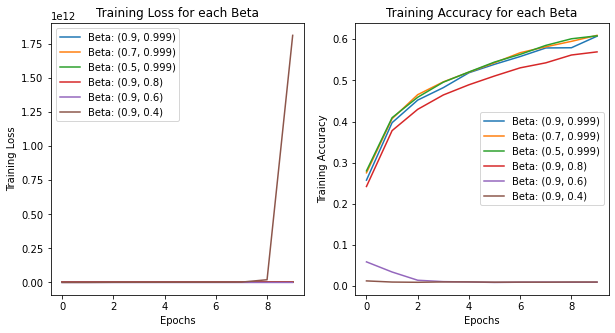

In [11]:
betas = [(0.9, 0.999), (0.7, 0.999), (0.5, 0.999), (0.9, 0.8), (0.9, 0.6), (0.9, 0.4)]
train_loss_adam_betas = []
train_accuracy_adam_betas = []
for beta in betas:
    model_adam = models.resnet18(pretrained=True).to(device)
    model_adam.fc = nn.Linear(512, 100).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001, betas=beta, weight_decay=0) 
    train_loss_adam_beta = []
    train_accuracy_adam_beta = []
    print("Training with betas: ", beta)
    train_loss_adam_beta, train_accuracy_adam_beta = train_model(model_adam, optimizer_adam, 10, train_loss_adam_beta, train_accuracy_adam_beta)
    print("--------------------------------------------")
    train_loss_adam_betas.append(train_loss_adam_beta)
    train_accuracy_adam_betas.append(train_accuracy_adam_beta)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Beta")
for i in range(len(betas)):
    plt.plot(train_loss_adam_betas[i], label="Beta: " + str(betas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Beta")
for i in range(len(betas)):
    plt.plot(train_accuracy_adam_betas[i], label="Beta: " + str(betas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Plotting only for the appropriate values of beta1 and beta2

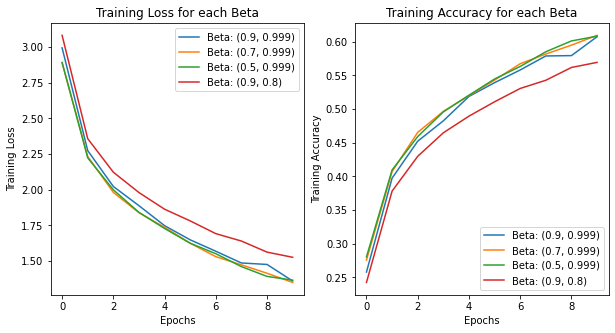

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Beta")
for i in range(len(betas)-2):
    plt.plot(train_loss_adam_betas[i], label="Beta: " + str(betas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Beta")
for i in range(len(betas)-2):
    plt.plot(train_accuracy_adam_betas[i], label="Beta: " + str(betas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning the lr_decay parameter for AdaGrad Optimizer. (Learning rate decay)

In [19]:
lr_decays = [0.1, 0.01, 0.001, 0.0001, 0.00001]
train_loss_adagrad_lr = []
train_accuracy_adagrad_lr = []
for lr_decay in lr_decays:
    model_adagrad = models.resnet18(pretrained=True).to(device)
    model_adagrad.fc = nn.Linear(512, 100).to(device)
    optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.001, lr_decay=lr_decay)
    train_loss_adagrad_ = []
    train_accuracy_adagrad_ = []
    print("Training with learning rate decay: ", lr_decay)
    train_loss_adagrad_, train_accuracy_adagrad_ = train_model(model_adagrad, optimizer_adagrad, 10, train_loss_adagrad_, train_accuracy_adagrad_)
    print("--------------------------------------------")
    train_loss_adagrad_lr.append(train_loss_adagrad_)
    train_accuracy_adagrad_lr.append(train_accuracy_adagrad_)

Training with learning rate decay:  0.1
Epoch: 1 Training Loss:  4.07604386068671 	 Training Accuracy:  0.11632
Epoch: 2 Training Loss:  3.9321403972937934 	 Training Accuracy:  0.1381
Epoch: 3 Training Loss:  3.9044413816593493 	 Training Accuracy:  0.14242
Epoch: 4 Training Loss:  3.8973192906440675 	 Training Accuracy:  0.14248
Epoch: 5 Training Loss:  3.885733932485361 	 Training Accuracy:  0.14502
Epoch: 6 Training Loss:  3.878275038336244 	 Training Accuracy:  0.1466
Epoch: 7 Training Loss:  3.8780726618169212 	 Training Accuracy:  0.14746
Epoch: 8 Training Loss:  3.873514583348618 	 Training Accuracy:  0.1468
Epoch: 9 Training Loss:  3.869628351972536 	 Training Accuracy:  0.14602
Epoch: 10 Training Loss:  3.8693313159601157 	 Training Accuracy:  0.1489
Training complete!
--------------------------------------------
Training with learning rate decay:  0.01
Epoch: 1 Training Loss:  3.3170599144742923 	 Training Accuracy:  0.22766
Epoch: 2 Training Loss:  2.862199185144566 	 Train

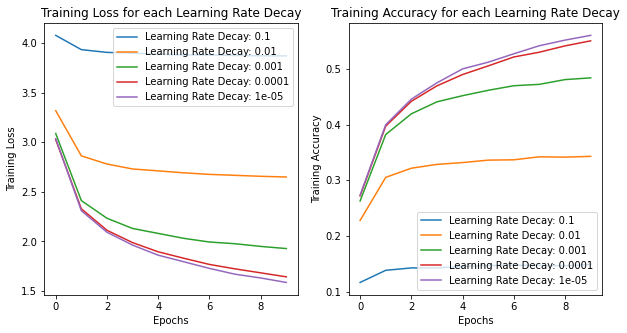

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Learning Rate Decay")
for i in range(len(lr_decays)):
    plt.plot(train_loss_adagrad_lr[i], label="Learning Rate Decay: " + str(lr_decays[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Learning Rate Decay")
for i in range(len(lr_decays)):
    plt.plot(train_accuracy_adagrad_lr[i], label="Learning Rate Decay: " + str(lr_decays[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning epsilon parameter for AdaGrad Optimizer.

In [17]:
eps = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2]
train_loss_adagrad_eps = []
train_accuracy_adagrad_eps = []
for ep in eps:
    model_adagrad = models.resnet18(pretrained=True).to(device)
    model_adagrad.fc = nn.Linear(512, 100).to(device)
    optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.001, eps=ep)
    train_loss_adagrad_ep = []
    train_accuracy_adagrad_ep = []
    print("Training with epsilon: ", ep)
    train_loss_adagrad_ep, train_accuracy_adagrad_ep = train_model(model_adagrad, optimizer_adagrad, 10, train_loss_adagrad_ep, train_accuracy_adagrad_ep)
    print("--------------------------------------------")
    train_loss_adagrad_eps.append(train_loss_adagrad_ep)
    train_accuracy_adagrad_eps.append(train_accuracy_adagrad_ep)

Training with epsilon:  1e-10
Epoch: 1 Training Loss:  3.0601474897330982 	 Training Accuracy:  0.26268
Epoch: 2 Training Loss:  2.3185983475516823 	 Training Accuracy:  0.3973
Epoch: 3 Training Loss:  2.103341852917391 	 Training Accuracy:  0.44298
Epoch: 4 Training Loss:  1.9646905596603823 	 Training Accuracy:  0.47332
Epoch: 5 Training Loss:  1.8608451261544776 	 Training Accuracy:  0.49706
Epoch: 6 Training Loss:  1.7897724922355789 	 Training Accuracy:  0.51378
Epoch: 7 Training Loss:  1.7215086703410234 	 Training Accuracy:  0.53112
Epoch: 8 Training Loss:  1.6608611272119196 	 Training Accuracy:  0.54746
Epoch: 9 Training Loss:  1.6229319843794683 	 Training Accuracy:  0.55464
Epoch: 10 Training Loss:  1.5867294734701172 	 Training Accuracy:  0.56178
Training complete!
--------------------------------------------
Training with epsilon:  1e-08
Epoch: 1 Training Loss:  3.0303722708426473 	 Training Accuracy:  0.27112
Epoch: 2 Training Loss:  2.3083412095408917 	 Training Accuracy

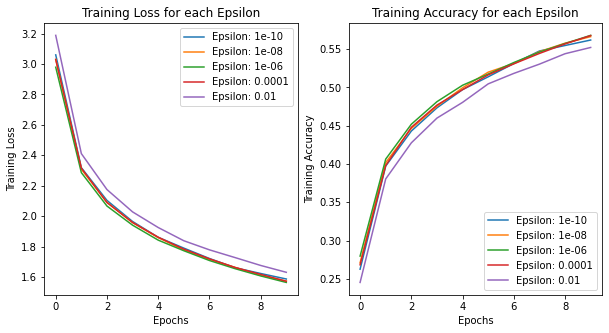

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Epsilon")
for i in range(len(eps)):
    plt.plot(train_loss_adagrad_eps[i], label="Epsilon: " + str(eps[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Epsilon")
for i in range(len(eps)):
    plt.plot(train_accuracy_adagrad_eps[i], label="Epsilon: " + str(eps[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning momentum parameter for RMSProp Optimizer (Momentum factor)

In [11]:
momentum_ = [0.1, 0.3, 0.5, 0.7, 0.9]
train_loss_rmsprop_momentum = []
train_accuracy_rmsprop_momentum = []
for momentum in momentum_:
    model_rmsprop = models.resnet18(pretrained=True).to(device)
    model_rmsprop.fc = nn.Linear(512, 100).to(device)
    optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.001, momentum=momentum)
    train_loss_rmsprop_m = []
    train_accuracy_rmsprop_m = []
    print("Training with momentum: ", momentum)
    train_loss_rmsprop_m, train_accuracy_rmsprop_m = train_model(model_rmsprop, optimizer_rmsprop, 10, train_loss_rmsprop_m, train_accuracy_rmsprop_m)
    print("--------------------------------------------")
    train_loss_rmsprop_momentum.append(train_loss_rmsprop_m)
    train_accuracy_rmsprop_momentum.append(train_accuracy_rmsprop_m)

Training with momentum:  0.1
Epoch: 1 Training Loss:  4.244732854311423 	 Training Accuracy:  0.05666
Epoch: 2 Training Loss:  3.3522810283524302 	 Training Accuracy:  0.1703
Epoch: 3 Training Loss:  2.8648968962452295 	 Training Accuracy:  0.25874
Epoch: 4 Training Loss:  2.581765698045111 	 Training Accuracy:  0.31826
Epoch: 5 Training Loss:  2.4057608455648203 	 Training Accuracy:  0.35658
Epoch: 6 Training Loss:  2.283263002515144 	 Training Accuracy:  0.38796
Epoch: 7 Training Loss:  2.148787312800317 	 Training Accuracy:  0.41796
Epoch: 8 Training Loss:  2.05952332361275 	 Training Accuracy:  0.43792
Epoch: 9 Training Loss:  1.9802854051980217 	 Training Accuracy:  0.45508
Epoch: 10 Training Loss:  1.917696694583844 	 Training Accuracy:  0.47368
Training complete!
--------------------------------------------
Training with momentum:  0.3
Epoch: 1 Training Loss:  4.410469617380206 	 Training Accuracy:  0.03646
Epoch: 2 Training Loss:  3.750757252163899 	 Training Accuracy:  0.11336

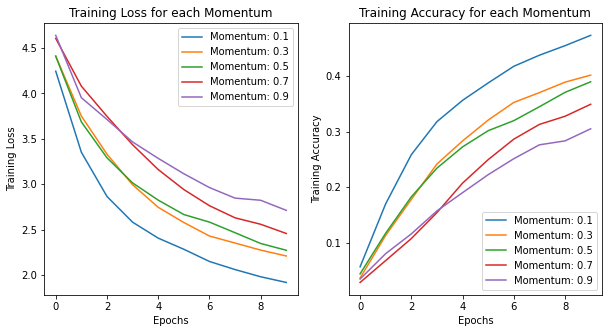

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Momentum")
for i in range(len(momentum_)):
    plt.plot(train_loss_rmsprop_momentum[i], label="Momentum: " + str(momentum_[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Momentum")
for i in range(len(momentum_)):
    plt.plot(train_accuracy_rmsprop_momentum[i], label="Momentum: " + str(momentum_[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning alpha parameter for RMSProp Optimizer (Smoothing constant)

In [13]:
alphas = [0.9, 0.99, 0.999, 0.9999]
train_loss_rmsprop_alpha = []
train_accuracy_rmsprop_alpha = []
for alpha in alphas:
    model_rmsprop = models.resnet18(pretrained=True).to(device)
    model_rmsprop.fc = nn.Linear(512, 100).to(device)
    optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.001, alpha=alpha)
    train_loss_rmsprop_a = []
    train_accuracy_rmsprop_a = []
    print("Training with alpha: ", alpha)
    train_loss_rmsprop_a, train_accuracy_rmsprop_a = train_model(model_rmsprop, optimizer_rmsprop, 10, train_loss_rmsprop_a, train_accuracy_rmsprop_a)
    print("--------------------------------------------")
    train_loss_rmsprop_alpha.append(train_loss_rmsprop_a)
    train_accuracy_rmsprop_alpha.append(train_accuracy_rmsprop_a)

Training with alpha:  0.9
Epoch: 1 Training Loss:  2.9943562297869826 	 Training Accuracy:  0.25824
Epoch: 2 Training Loss:  2.2796917464727025 	 Training Accuracy:  0.39692
Epoch: 3 Training Loss:  2.0372019231776752 	 Training Accuracy:  0.44952
Epoch: 4 Training Loss:  1.8919679801482374 	 Training Accuracy:  0.48388
Epoch: 5 Training Loss:  1.7705943020408417 	 Training Accuracy:  0.51388
Epoch: 6 Training Loss:  1.6644844146030944 	 Training Accuracy:  0.53716
Epoch: 7 Training Loss:  1.5903573490469658 	 Training Accuracy:  0.55434
Epoch: 8 Training Loss:  1.504642882005638 	 Training Accuracy:  0.57752
Epoch: 9 Training Loss:  1.4496418076098119 	 Training Accuracy:  0.5883
Epoch: 10 Training Loss:  1.3945915802665378 	 Training Accuracy:  0.60378
Training complete!
--------------------------------------------
Training with alpha:  0.99
Epoch: 1 Training Loss:  4.086127008013713 	 Training Accuracy:  0.07806
Epoch: 2 Training Loss:  3.1294870711958316 	 Training Accuracy:  0.213

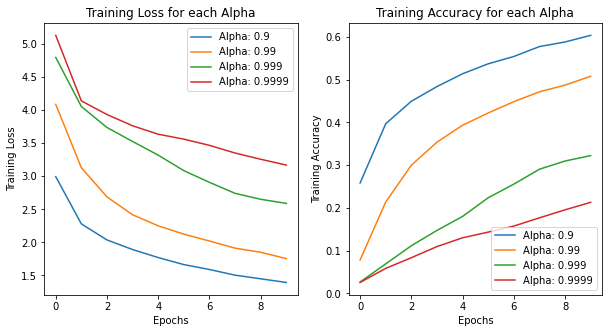

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Alpha")
for i in range(len(alphas)):
    plt.plot(train_loss_rmsprop_alpha[i], label="Alpha: " + str(alphas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Alpha")
for i in range(len(alphas)):
    plt.plot(train_accuracy_rmsprop_alpha[i], label="Alpha: " + str(alphas[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning centered parameter for RMSProp Optimizer (If True, gradients are normalized by the estimated variance of the gradient; if False, by the uncentered second moment)

Note: By default, centered is set to False.

In [16]:
model_rmsprop_centered = models.resnet18(pretrained=True).to(device)
model_rmsprop_centered.fc = nn.Linear(512, 100).to(device)
optimizer_rmsprop_centered = optim.RMSprop(model_rmsprop_centered.parameters(), lr=0.001, centered=True)
train_loss_rmsprop_centered = []
train_accuracy_rmsprop_centered = []
print("Training with centered: True")
train_loss_rmsprop_centered, train_accuracy_rmsprop_centered = train_model(model_rmsprop_centered, optimizer_rmsprop_centered, 10, train_loss_rmsprop_centered, train_accuracy_rmsprop_centered)

Training with centered: True
Epoch: 1 Training Loss:  4.039591121551631 	 Training Accuracy:  0.08192
Epoch: 2 Training Loss:  3.125606535645702 	 Training Accuracy:  0.21268
Epoch: 3 Training Loss:  2.7022098854679584 	 Training Accuracy:  0.2966
Epoch: 4 Training Loss:  2.4560230662450766 	 Training Accuracy:  0.3474
Epoch: 5 Training Loss:  2.2802950823703387 	 Training Accuracy:  0.38746
Epoch: 6 Training Loss:  2.148284745643206 	 Training Accuracy:  0.41686
Epoch: 7 Training Loss:  2.059338809888991 	 Training Accuracy:  0.4378
Epoch: 8 Training Loss:  1.9541626976579047 	 Training Accuracy:  0.46274
Epoch: 9 Training Loss:  1.9003838889129328 	 Training Accuracy:  0.47528
Epoch: 10 Training Loss:  1.8393434972104514 	 Training Accuracy:  0.4888
Training complete!


### Plot between the training loss and accuracy for RMSProp Optimizer with centered = True and centered = False

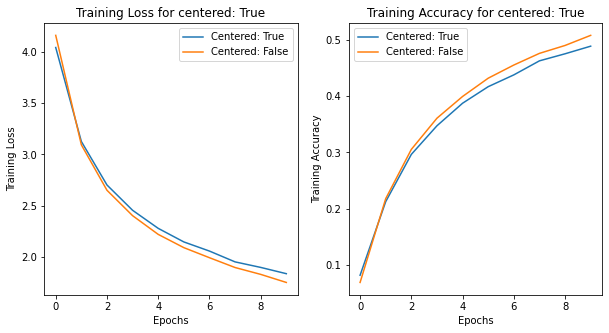

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for centered: True")
plt.plot(train_loss_rmsprop_centered, label="Centered: True")
plt.plot(train_loss_rmsprop, label="Centered: False")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for centered: True")
plt.plot(train_accuracy_rmsprop_centered, label="Centered: True")
plt.plot(train_accuracy_rmsprop, label="Centered: False")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

### Tuning the learning rates for Adam, AdaGrad and RMSProp Optimizer

In [14]:
lr_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [15]:
train_loss_adam_lr = []
train_accuracy_adam_lr = []

for lr in lr_list:
    model_adam = models.resnet18(pretrained=True).to(device)
    model_adam.fc = nn.Linear(512, 100).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr)
    train_loss_adam = []
    train_accuracy_adam = []
    print("Training with Adam lr: ", lr)
    train_loss_adam, train_accuracy_adam = train_model(model_adam, optimizer_adam, 10, train_loss_adam, train_accuracy_adam)
    print("--------------------------------------------")
    train_loss_adam_lr.append(train_loss_adam)
    train_accuracy_adam_lr.append(train_accuracy_adam)

Training with Adam lr:  1e-05
Epoch: 1 Training Loss:  4.591629292958838 	 Training Accuracy:  0.03608
Epoch: 2 Training Loss:  4.06955484173182 	 Training Accuracy:  0.11006
Epoch: 3 Training Loss:  3.6349014107833435 	 Training Accuracy:  0.17938
Epoch: 4 Training Loss:  3.2889092590497886 	 Training Accuracy:  0.23278
Epoch: 5 Training Loss:  3.020432061246594 	 Training Accuracy:  0.27812
Epoch: 6 Training Loss:  2.8307478403496313 	 Training Accuracy:  0.3071
Epoch: 7 Training Loss:  2.663194081362556 	 Training Accuracy:  0.3388
Epoch: 8 Training Loss:  2.533437805102609 	 Training Accuracy:  0.36164
Epoch: 9 Training Loss:  2.4301463917393207 	 Training Accuracy:  0.37856
Epoch: 10 Training Loss:  2.333386838283685 	 Training Accuracy:  0.3997
Training complete!
--------------------------------------------
Training with Adam lr:  0.0001
Epoch: 1 Training Loss:  3.2910858194541444 	 Training Accuracy:  0.23304
Epoch: 2 Training Loss:  2.2427998692788127 	 Training Accuracy:  0.41

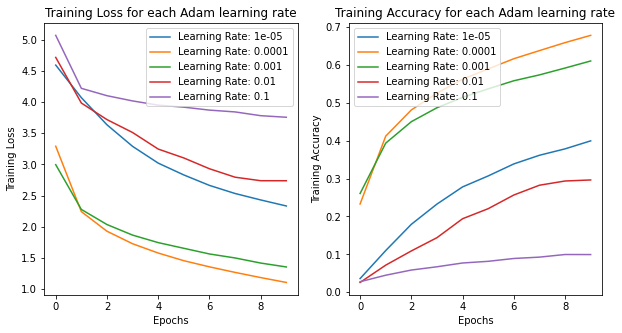

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Adam learning rate")
for i in range(len(lr_list)):
    plt.plot(train_loss_adam_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Adam learning rate")
for i in range(len(lr_list)):
    plt.plot(train_accuracy_adam_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

In [17]:
train_loss_adagrad_lr = []
train_accuracy_adagrad_lr = []
for lr in lr_list:    
    model_adagrad = models.resnet18(pretrained=True).to(device)
    model_adagrad.fc = nn.Linear(512, 100).to(device)
    optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=lr)
    train_loss_adagrad = []
    train_accuracy_adagrad = []
    print("Training with Adagrad lr: ", lr)
    train_loss_adagrad, train_accuracy_adagrad = train_model(model_adagrad, optimizer_adagrad, 10, train_loss_adagrad, train_accuracy_adagrad)
    print("--------------------------------------------")
    # Store the training loss and accuracy for each weight decay
    train_loss_adagrad_lr.append(train_loss_adagrad)
    train_accuracy_adagrad_lr.append(train_accuracy_adagrad)

Training with Adagrad lr:  1e-05
Epoch: 1 Training Loss:  4.951238568786465 	 Training Accuracy:  0.01116
Epoch: 2 Training Loss:  4.894292214337518 	 Training Accuracy:  0.01124
Epoch: 3 Training Loss:  4.854766783506974 	 Training Accuracy:  0.01236
Epoch: 4 Training Loss:  4.825516875137758 	 Training Accuracy:  0.01322
Epoch: 5 Training Loss:  4.798555480244825 	 Training Accuracy:  0.01372
Epoch: 6 Training Loss:  4.77573626120682 	 Training Accuracy:  0.01594
Epoch: 7 Training Loss:  4.764854864086336 	 Training Accuracy:  0.01642
Epoch: 8 Training Loss:  4.743712761822869 	 Training Accuracy:  0.01766
Epoch: 9 Training Loss:  4.724085901704286 	 Training Accuracy:  0.01824
Epoch: 10 Training Loss:  4.714180681711572 	 Training Accuracy:  0.02028
Training complete!
--------------------------------------------
Training with Adagrad lr:  0.0001
Epoch: 1 Training Loss:  4.50402503245322 	 Training Accuracy:  0.0444
Epoch: 2 Training Loss:  4.216032479425221 	 Training Accuracy:  0.0

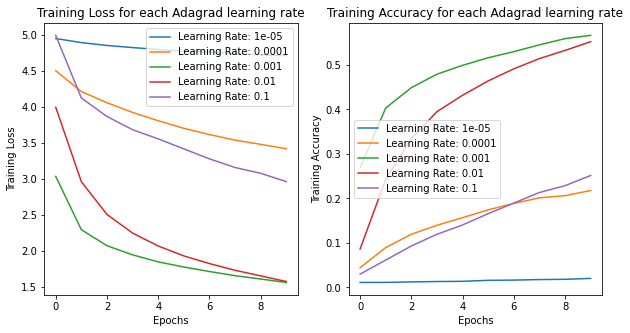

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each Adagrad learning rate")
for i in range(len(lr_list)):
    plt.plot(train_loss_adagrad_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each Adagrad learning rate")
for i in range(len(lr_list)):
    plt.plot(train_accuracy_adagrad_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

In [19]:
train_loss_rmsprop_lr = []
train_accuracy_rmsprop_lr = []
for lr in lr_list:
    model_rmsprop = models.resnet18(pretrained=True).to(device)
    model_rmsprop.fc = nn.Linear(512, 100).to(device)
    optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=lr)
    train_loss_rmsprop = []
    train_accuracy_rmsprop = []
    print("Training with RMSprop lr: ", lr)
    train_loss_rmsprop, train_accuracy_rmsprop = train_model(model_rmsprop, optimizer_rmsprop, 10, train_loss_rmsprop, train_accuracy_rmsprop)
    print("--------------------------------------------")
    # Store the training loss and accuracy for each weight decay
    train_loss_rmsprop_lr.append(train_loss_rmsprop)
    train_accuracy_rmsprop_lr.append(train_accuracy_rmsprop)

Training with RMSprop lr:  1e-05
Epoch: 1 Training Loss:  4.417126702530609 	 Training Accuracy:  0.06162
Epoch: 2 Training Loss:  3.845797018626767 	 Training Accuracy:  0.15038
Epoch: 3 Training Loss:  3.437335158248082 	 Training Accuracy:  0.21328
Epoch: 4 Training Loss:  3.1336944200803556 	 Training Accuracy:  0.26152
Epoch: 5 Training Loss:  2.8947374906076493 	 Training Accuracy:  0.29952
Epoch: 6 Training Loss:  2.718252009443005 	 Training Accuracy:  0.33232
Epoch: 7 Training Loss:  2.5792111338251997 	 Training Accuracy:  0.35298
Epoch: 8 Training Loss:  2.4658267235816895 	 Training Accuracy:  0.3735
Epoch: 9 Training Loss:  2.367093366735122 	 Training Accuracy:  0.39368
Epoch: 10 Training Loss:  2.284696715872001 	 Training Accuracy:  0.41106
Training complete!
--------------------------------------------
Training with RMSprop lr:  0.0001
Epoch: 1 Training Loss:  2.963743470818795 	 Training Accuracy:  0.2819
Epoch: 2 Training Loss:  2.1533857032161237 	 Training Accuracy

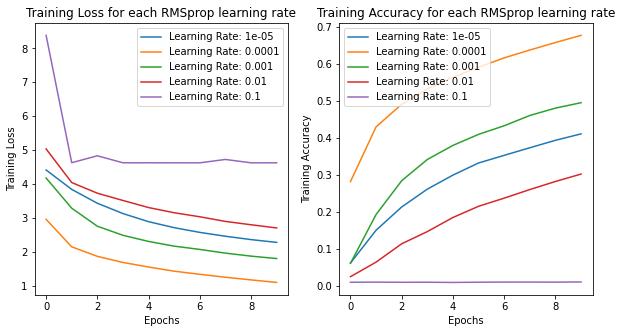

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss for each RMSprop learning rate")
for i in range(len(lr_list)):
    plt.plot(train_loss_rmsprop_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy for each RMSprop learning rate")
for i in range(len(lr_list)):
    plt.plot(train_accuracy_rmsprop_lr[i], label="Learning Rate: " + str(lr_list[i]))
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.show()

---